In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from tpot import TPOTRegressor
import re

# Final project - Nate Cook

The main question of this notebook is can I predict the amount of arrests per game based on various factors. Some other questions I have is what team has the most average arrests per game, what factors lead to the most arrests, and what day has the most arrests on average.

## 1 - Looking at the data

### 1.1 - Data Description
- `season`: The NFL season year. Int
- `week_num`: The week number of the NFL season. Int
- `day_of_week`: The day of the week the game was played. String
- `gametime_local`: The local time the game started. String
- `home_team`: The name of the home team. String
- `away_team`: The name of the away team. String
- `home_score`: The score of the home team. Int
- `away_score`: The score of the away team. Int
- `OT_flag`: Indicates if the game went into overtime. String (e.g., "OT" or empty)
- `arrests`: The number of arrests made during and after the game. Int
- `division_game`: Indicates if the game was a divisional matchup. String (e.g., "y" or "n")

### 1.2 - Data overview

In [5]:
# Load data
df = pd.read_csv("nfl_arrests_2011-2015.csv")
print(f"Dataset shape: {df.shape}")

Dataset shape: (1006, 11)


In [6]:
# Display the first 10 rows
display(df.head(10))

,season,week_num,day_of_week,gametime_local,home_team,away_team,home_score,away_score,OT_flag,arrests,division_game
0,2011,1,Sunday,1:15:00 PM,Arizona,Carolina,28,21,NaN,5.0,n
1,2011,4,Sunday,1:05:00 PM,Arizona,New York Giants,27,31,NaN,6.0,n
2,2011,7,Sunday,1:05:00 PM,Arizona,Pittsburgh,20,32,NaN,9.0,n
3,2011,9,Sunday,2:15:00 PM,Arizona,St. Louis,19,13,OT,6.0,y
4,2011,13,Sunday,2:15:00 PM,Arizona,Dallas,19,13,OT,3.0,n
5,2011,14,Sunday,2:05:00 PM,Arizona,San Francisco,21,19,NaN,4.0,y
6,2011,15,Sunday,2:15:00 PM,Arizona,Cleveland,20,17,OT,1.0,n
7,2011,17,Sunday,2:15:00 PM,Arizona,Seattle,23,20,OT,4.0,y
8,2012,1,Sunday,1:25:00 PM,Arizona,Seattle,20,16,NaN,0.0,y
9,2012,3,Sunday,1:05:00 PM,Arizona,Philadelphia,27,6,NaN,12.0,n


In [7]:
# Describe the data
df.describe()

,season,week_num,home_score,away_score,arrests
count,1006.000000,1006.000000,1006.000000,1006.000000,966.000000
mean,2013.000000,9.116302,23.934394,21.115308,6.566253
std,1.406453,5.008986,10.442626,9.734006,9.512101
min,2011.000000,1.000000,0.000000,0.000000,0.000000
25%,2012.000000,5.000000,17.000000,14.000000,1.000000
50%,2013.000000,9.000000,23.000000,20.000000,3.000000
75%,2014.000000,14.000000,30.000000,27.000000,8.000000
max,2015.000000,17.000000,59.000000,56.000000,69.000000


In [8]:
# Get the info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          1006 non-null   int64  
 1   week_num        1006 non-null   int64  
 2   day_of_week     1006 non-null   object 
 3   gametime_local  1006 non-null   object 
 4   home_team       1006 non-null   object 
 5   away_team       1006 non-null   object 
 6   home_score      1006 non-null   int64  
 7   away_score      1006 non-null   int64  
 8   OT_flag         59 non-null     object 
 9   arrests         966 non-null    float64
 10  division_game   1006 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 86.6+ KB


From this overview of the data my first big problem appears with the amount of categorical features. There is a heavy amount of categorical data I need to convert, but most of it shouldn't be bad. I could convert the ot flag to 0 if false and 1 if true and do the same for division game. I can convert game time and day to integers as well, but converting teams through one hot encoding might make the data set to large. I need to research some ideas.

### 1.5 - Check for nulls

In [9]:
# Check for null values
nulls = df.isnull().sum()
print("\nNull values per column:")
print(nulls)


Null values per column:
season              0
week_num            0
day_of_week         0
gametime_local      0
home_team           0
away_team           0
home_score          0
away_score          0
OT_flag           947
arrests            40
division_game       0
dtype: int64


A lot of nulls in OT_Flag but that will be fixed in cleaning and arrests will just be filled with mean in cleaning as well

### 1.7 - Finding basic stats

In [10]:
# Games per season
print("\nGames per season:")
display(df['season'].value_counts().sort_index())


Games per season:


season
2011    199
2012    200
2013    206
2014    204
2015    197
Name: count, dtype: int64

In [11]:
# Games per day
print("\nGames per day of week:")
display(df['day_of_week'].value_counts())


Games per day of week:


day_of_week
Sunday       855
Monday        70
Thursday      64
Saturday      16
Wednesday      1
Name: count, dtype: int64

In [12]:
# Mean arrests per game
print("\nMean arrests per game:", df['arrests'].mean())


Mean arrests per game: 6.566252587991719


## 2 - Cleaning the data

This is a hard section for me because I want to fill nulls, convert, add features, and scale them all before I can start to run predications on anything

### 2.1 - Fill null values

In [13]:
# Fill null ot flag values with N
df['OT_flag'] = df['OT_flag'].fillna('N')

# Check to see if it worked
nulls = df.isnull().sum()
print("\nNull values per column:")
print(nulls)


Null values per column:
season             0
week_num           0
day_of_week        0
gametime_local     0
home_team          0
away_team          0
home_score         0
away_score         0
OT_flag            0
arrests           40
division_game      0
dtype: int64


In [14]:
# Next fill all numerical features with mean
numeric_columns = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

# Check to see if it worked
nulls = df.isnull().sum()
print("\nNull values per column:")
print(nulls)


Null values per column:
season            0
week_num          0
day_of_week       0
gametime_local    0
home_team         0
away_team         0
home_score        0
away_score        0
OT_flag           0
arrests           0
division_game     0
dtype: int64


Now all nulls are filled, so now we can start to convert

### 2.5 - Convert categorical to numerical

First im going to start with one hot encoding the day of the week

In [15]:
df["day_of_week"].value_counts()

day_of_week
Sunday       855
Monday        70
Thursday      64
Saturday      16
Wednesday      1
Name: count, dtype: int64

5 Values means 5 features will be add, but it is very annoying that I have to add wednesday as a feature even though it only appears once

In [16]:
# Day of week to numerical
day_encoder = OneHotEncoder(sparse_output=False)
day_encoded = day_encoder.fit_transform(df[['day_of_week']])
day_encoded_df = pd.DataFrame(day_encoded, columns=[f'day_{cat}' for cat in day_encoder.categories_[0]])
df = pd.concat([df, day_encoded_df], axis=1)
df.drop('day_of_week', axis=1, inplace=True)

display(df.head(10))

,season,week_num,gametime_local,home_team,away_team,home_score,away_score,OT_flag,arrests,division_game,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Wednesday
0,2011.0,1.0,1:15:00 PM,Arizona,Carolina,28.0,21.0,N,5.0,n,0.0,0.0,1.0,0.0,0.0
1,2011.0,4.0,1:05:00 PM,Arizona,New York Giants,27.0,31.0,N,6.0,n,0.0,0.0,1.0,0.0,0.0
2,2011.0,7.0,1:05:00 PM,Arizona,Pittsburgh,20.0,32.0,N,9.0,n,0.0,0.0,1.0,0.0,0.0
3,2011.0,9.0,2:15:00 PM,Arizona,St. Louis,19.0,13.0,OT,6.0,y,0.0,0.0,1.0,0.0,0.0
4,2011.0,13.0,2:15:00 PM,Arizona,Dallas,19.0,13.0,OT,3.0,n,0.0,0.0,1.0,0.0,0.0
5,2011.0,14.0,2:05:00 PM,Arizona,San Francisco,21.0,19.0,N,4.0,y,0.0,0.0,1.0,0.0,0.0
6,2011.0,15.0,2:15:00 PM,Arizona,Cleveland,20.0,17.0,OT,1.0,n,0.0,0.0,1.0,0.0,0.0
7,2011.0,17.0,2:15:00 PM,Arizona,Seattle,23.0,20.0,OT,4.0,y,0.0,0.0,1.0,0.0,0.0
8,2012.0,1.0,1:25:00 PM,Arizona,Seattle,20.0,16.0,N,0.0,y,0.0,0.0,1.0,0.0,0.0
9,2012.0,3.0,1:05:00 PM,Arizona,Philadelphia,27.0,6.0,N,12.0,n,0.0,0.0,1.0,0.0,0.0


Next is teams

In [17]:
df["home_team"].value_counts()

home_team
Arizona            40
Carolina           40
Green Bay          40
Cincinnati         40
Dallas             40
Denver             40
Houston            40
Detroit            40
New York Jets      40
Indianapolis       40
Seattle            40
Tennessee          40
New York Giants    40
New England        40
San Francisco      40
San Diego          40
Pittsburgh         40
Philadelphia       40
Washington         40
Kansas City        39
Tampa Bay          39
Jacksonville       37
Oakland            37
Chicago            32
Baltimore          31
Miami              31
Name: count, dtype: int64

There is defiantly too many teams here to one hot encode because I have to do away and home. After researching only I think label encoding will work the best out of my options. How this will work is it will assign each home and away team a integer value that will correspond to the team. It shouldn't be to bad to make it work for this.

In [18]:
# Team encoding
all_teams = sorted(set(df['home_team'].unique()).union(set(df['away_team'].unique())))
team_to_id = {team: idx for idx, team in enumerate(all_teams)}

df['home_team_id'] = df['home_team'].map(team_to_id)
df['away_team_id'] = df['away_team'].map(team_to_id)
df.drop(['home_team', 'away_team'], axis=1, inplace=True)

display(df.head(10))

,season,week_num,gametime_local,home_score,away_score,OT_flag,arrests,division_game,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Wednesday,home_team_id,away_team_id
0,2011.0,1.0,1:15:00 PM,28.0,21.0,N,5.0,n,0.0,0.0,1.0,0.0,0.0,0,4
1,2011.0,4.0,1:05:00 PM,27.0,31.0,N,6.0,n,0.0,0.0,1.0,0.0,0.0,0,20
2,2011.0,7.0,1:05:00 PM,20.0,32.0,N,9.0,n,0.0,0.0,1.0,0.0,0.0,0,24
3,2011.0,9.0,2:15:00 PM,19.0,13.0,OT,6.0,y,0.0,0.0,1.0,0.0,0.0,0,28
4,2011.0,13.0,2:15:00 PM,19.0,13.0,OT,3.0,n,0.0,0.0,1.0,0.0,0.0,0,8
5,2011.0,14.0,2:05:00 PM,21.0,19.0,N,4.0,y,0.0,0.0,1.0,0.0,0.0,0,26
6,2011.0,15.0,2:15:00 PM,20.0,17.0,OT,1.0,n,0.0,0.0,1.0,0.0,0.0,0,7
7,2011.0,17.0,2:15:00 PM,23.0,20.0,OT,4.0,y,0.0,0.0,1.0,0.0,0.0,0,27
8,2012.0,1.0,1:25:00 PM,20.0,16.0,N,0.0,y,0.0,0.0,1.0,0.0,0.0,0,27
9,2012.0,3.0,1:05:00 PM,27.0,6.0,N,12.0,n,0.0,0.0,1.0,0.0,0.0,0,23


In [19]:
# Print out the table of the id with the team
team_encoding_df = pd.DataFrame(list(team_to_id.items()), columns=['Team', 'Team_ID'])
display(team_encoding_df.sort_values('Team_ID'))

,Team,Team_ID
0,Arizona,0
1,Atlanta,1
2,Baltimore,2
3,Buffalo,3
4,Carolina,4
5,Chicago,5
6,Cincinnati,6
7,Cleveland,7
8,Dallas,8
9,Denver,9


Label encoding worked great here and now I just have to fix a couple more values and I should be done with converting soon

In [20]:
# Convert OT_flag and division_game to 0 and 1
df['overtime'] = df['OT_flag'].apply(lambda x: 1 if x == 'OT' else 0)
df.drop('OT_flag', axis=1, inplace=True)

# Convert division_game
df['division_game'] = df['division_game'].apply(lambda x: 1 if x.lower() == 'y' else 0)

# Check if worked
display(df.head(10))

,season,week_num,gametime_local,home_score,away_score,arrests,division_game,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Wednesday,home_team_id,away_team_id,overtime
0,2011.0,1.0,1:15:00 PM,28.0,21.0,5.0,0,0.0,0.0,1.0,0.0,0.0,0,4,0
1,2011.0,4.0,1:05:00 PM,27.0,31.0,6.0,0,0.0,0.0,1.0,0.0,0.0,0,20,0
2,2011.0,7.0,1:05:00 PM,20.0,32.0,9.0,0,0.0,0.0,1.0,0.0,0.0,0,24,0
3,2011.0,9.0,2:15:00 PM,19.0,13.0,6.0,1,0.0,0.0,1.0,0.0,0.0,0,28,1
4,2011.0,13.0,2:15:00 PM,19.0,13.0,3.0,0,0.0,0.0,1.0,0.0,0.0,0,8,1
5,2011.0,14.0,2:05:00 PM,21.0,19.0,4.0,1,0.0,0.0,1.0,0.0,0.0,0,26,0
6,2011.0,15.0,2:15:00 PM,20.0,17.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0,7,1
7,2011.0,17.0,2:15:00 PM,23.0,20.0,4.0,1,0.0,0.0,1.0,0.0,0.0,0,27,1
8,2012.0,1.0,1:25:00 PM,20.0,16.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0,27,0
9,2012.0,3.0,1:05:00 PM,27.0,6.0,12.0,0,0.0,0.0,1.0,0.0,0.0,0,23,0


Lastly I need to convert game time to numerical. This turned out to be pretty hard because I tried to convert to hours and just round, but that didn't work at all and messed up the data anyways. After looking online for a bit I found the re library and a stack overflow question with basically the same problem and just used the function in there and it worked great.

In [21]:
# Convert game time
def time_to_minutes(time_str):
    match = re.search(r'(\d+):(\d+):(\d+)\s*([AP]M)', time_str)
    if match:
        hour, minute, second, period = match.groups()
        hour = int(hour)
        if period == 'PM' and hour < 12:
            hour += 12
        elif period == 'AM' and hour == 12:
            hour = 0
        return hour * 60 + int(minute)
    return None

df['game_minutes'] = df['gametime_local'].apply(time_to_minutes)
df.drop('gametime_local', axis=1, inplace=True)

# Check if worked
display(df.head(10))

,season,week_num,home_score,away_score,arrests,division_game,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Wednesday,home_team_id,away_team_id,overtime,game_minutes
0,2011.0,1.0,28.0,21.0,5.0,0,0.0,0.0,1.0,0.0,0.0,0,4,0,795
1,2011.0,4.0,27.0,31.0,6.0,0,0.0,0.0,1.0,0.0,0.0,0,20,0,785
2,2011.0,7.0,20.0,32.0,9.0,0,0.0,0.0,1.0,0.0,0.0,0,24,0,785
3,2011.0,9.0,19.0,13.0,6.0,1,0.0,0.0,1.0,0.0,0.0,0,28,1,855
4,2011.0,13.0,19.0,13.0,3.0,0,0.0,0.0,1.0,0.0,0.0,0,8,1,855
5,2011.0,14.0,21.0,19.0,4.0,1,0.0,0.0,1.0,0.0,0.0,0,26,0,845
6,2011.0,15.0,20.0,17.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0,7,1,855
7,2011.0,17.0,23.0,20.0,4.0,1,0.0,0.0,1.0,0.0,0.0,0,27,1,855
8,2012.0,1.0,20.0,16.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0,27,0,805
9,2012.0,3.0,27.0,6.0,12.0,0,0.0,0.0,1.0,0.0,0.0,0,23,0,785


Now after all the conversion I got every feature to numerical and I didn't have to use one hot encoding much so the data set isn't extremely big either. Now I want to add a couple more features to help the future analysis.

### 2.7 - Feature engineering

For the features I decided I want to add I went with total points, score difference, home team win, high scoring, and game competitiveness all of which will be explained in more code comments when in their cells.

In [22]:
# First is total points which is just home + away points added together
df['total_points'] = df['home_score'] + df['away_score']

In [23]:
# Next is score difference which is the difference between the two teams scoring
df['score_diff'] = df['home_score'] - df['away_score']

In [24]:
# Now home team win is added which is just seeing whether the home team won and if they did a 1 is recorded and if not a 0 is recorded
df['home_win'] = (df['score_diff'] > 0).astype(int)

In [25]:
# Next is high scoring which finds the average score of the games and if it is above records a 1 and if not it records a 0
median_score = df['total_points'].median()
df['high_scoring'] = (df['total_points'] > median_score).astype(int)

In [26]:
# Lastly is game competitiveness which uses how close the score was to find if they game was competitive
df['competitive_game'] = 1 - (abs(df['score_diff']) / df['total_points'])

Now we can check if they all worked

In [27]:
display(df.head(10))

,season,week_num,home_score,away_score,arrests,division_game,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Wednesday,home_team_id,away_team_id,overtime,game_minutes,total_points,score_diff,home_win,high_scoring,competitive_game
0,2011.0,1.0,28.0,21.0,5.0,0,0.0,0.0,1.0,0.0,0.0,0,4,0,795,49.0,7.0,1,1,0.857143
1,2011.0,4.0,27.0,31.0,6.0,0,0.0,0.0,1.0,0.0,0.0,0,20,0,785,58.0,-4.0,0,1,0.931034
2,2011.0,7.0,20.0,32.0,9.0,0,0.0,0.0,1.0,0.0,0.0,0,24,0,785,52.0,-12.0,0,1,0.769231
3,2011.0,9.0,19.0,13.0,6.0,1,0.0,0.0,1.0,0.0,0.0,0,28,1,855,32.0,6.0,1,0,0.812500
4,2011.0,13.0,19.0,13.0,3.0,0,0.0,0.0,1.0,0.0,0.0,0,8,1,855,32.0,6.0,1,0,0.812500
5,2011.0,14.0,21.0,19.0,4.0,1,0.0,0.0,1.0,0.0,0.0,0,26,0,845,40.0,2.0,1,0,0.950000
6,2011.0,15.0,20.0,17.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0,7,1,855,37.0,3.0,1,0,0.918919
7,2011.0,17.0,23.0,20.0,4.0,1,0.0,0.0,1.0,0.0,0.0,0,27,1,855,43.0,3.0,1,0,0.930233
8,2012.0,1.0,20.0,16.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0,27,0,805,36.0,4.0,1,0,0.888889
9,2012.0,3.0,27.0,6.0,12.0,0,0.0,0.0,1.0,0.0,0.0,0,23,0,785,33.0,21.0,1,0,0.363636


It looks perfect and now that those features are added its finally time to scale

### 2.7 - Splitting and Scaling

I forgot I need to split my data before so im going to do that quickly and then scale

In [28]:
# Define target variable and features
y = df['arrests']
X = df.drop('arrests', axis=1)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (804, 19)
Testing set shape: (202, 19)


Now I can actually scale

In [29]:
# Define which ones to scale because no point in scale the 0 and 1 columns
cols_to_scale = ['season', 'week_num', 'home_score', 'away_score', 
                'game_minutes', 'total_points', 'score_diff', 'competitive_game']

# Create and fit scaler using training data
scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# Apply the same to the test data
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])


Now that the training and test data is scaled I can output the head for each and see if I can finally be done with cleaning

In [30]:
print("Final training data after cleaning: ")
display(X_train.head(3))

print("Final test data after cleaning: ")
display(X_test.head(3))

Final training data after cleaning: 


,season,week_num,home_score,away_score,division_game,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Wednesday,home_team_id,away_team_id,overtime,game_minutes,total_points,score_diff,home_win,high_scoring,competitive_game
29,0.733208,0.400003,-0.967922,-1.551597,0,0.0,0.0,1.0,0.0,0.0,0,10,0,-0.052106,-1.842518,0.343751,1,0,-0.522450
280,0.020392,-0.994804,1.533740,1.110685,1,0.0,0.0,1.0,0.0,0.0,10,5,0,-0.565137,1.957590,0.343751,1,1,0.748763
507,0.020392,-1.194062,0.282909,0.189126,0,0.0,0.0,1.0,0.0,0.0,16,1,0,0.551460,0.349852,0.073787,1,1,0.885663


Final test data after cleaning: 


,season,week_num,home_score,away_score,division_game,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Wednesday,home_team_id,away_team_id,overtime,game_minutes,total_points,score_diff,home_win,high_scoring,competitive_game
927,-1.405242,-1.194062,-0.679269,-0.732433,0,0.0,0.0,1.0,0.0,0.0,30,9,0,-0.927277,-1.038649,0.006296,1,0,0.811850
630,0.020392,0.001487,0.186691,-0.118060,0,0.0,0.0,1.0,0.0,0.0,21,19,0,-0.565137,0.057536,0.208769,1,1,0.663732
682,1.446025,-0.197771,0.956433,-0.118060,0,0.0,0.0,1.0,0.0,0.0,22,21,0,-0.534959,0.642168,0.748697,1,1,0.096859


It looks good and now I am finally done with cleaning.

A quick summary of what I did with part 2 was I filled all nulls, converted all categorical data to numerical with one hot encoding and label encoding, I split the data into test and training data and made sure my target (arrests) was not included, I also added 5 new features to help with future analysis, and lastly I scaled both the test and training data. 

## 3 - Predictions

### 3.1 - Feature correlation and Distributions

Firstly, I want to look at the target variable more closely to help my future predictions

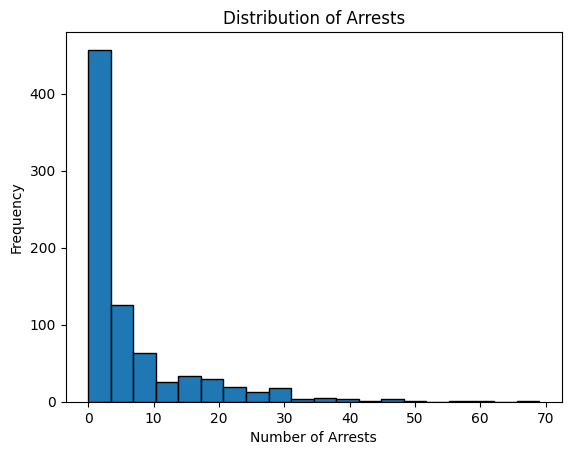

In [31]:
# Visualize arrests
import matplotlib.pyplot as plt
plt.hist(y_train, bins=20, edgecolor='black')
plt.title('Distribution of Arrests')
plt.xlabel('Number of Arrests')
plt.ylabel('Frequency')
plt.show()

From the graph you can see the mass majority of the arrests fall into the 0 - 10 range. This will be important in the future

Next, I want to make a feature correlation to see which features impact it the most

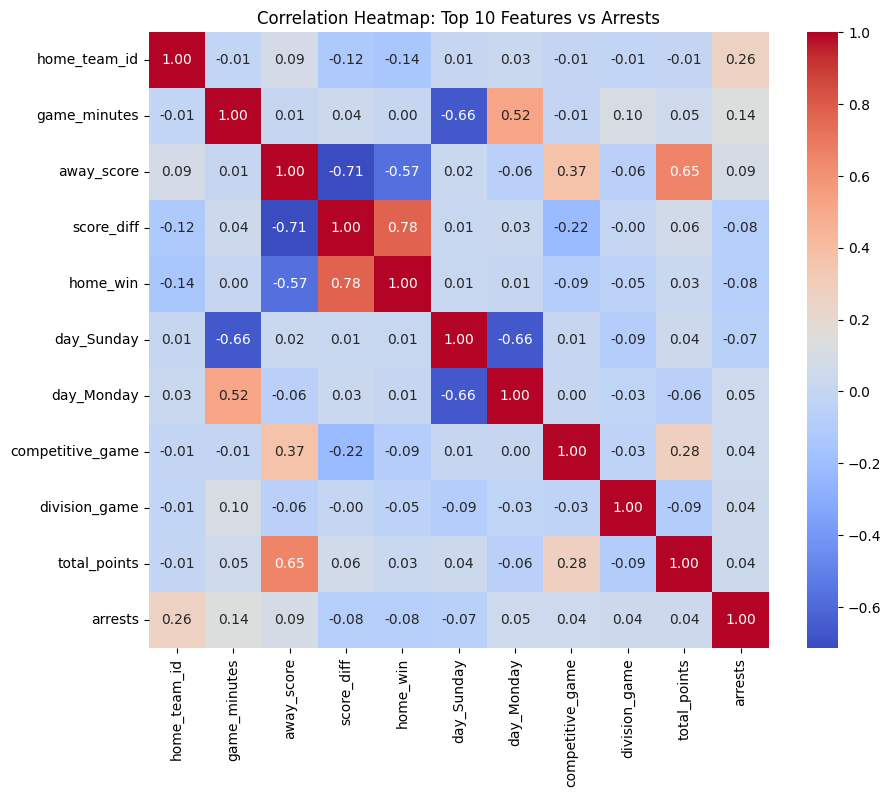

In [32]:
# Make the correlation matrix and the features
correlation_matrix = pd.concat([X_train, y_train], axis=1).corr()
top_features = correlation_matrix['arrests'].abs().sort_values(ascending=False)[1:11].index.tolist()
top_corr = correlation_matrix.loc[top_features + ['arrests'], top_features + ['arrests']]

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(top_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Top 10 Features vs Arrests')
plt.show()

From this graph you can see a lot of interesting features. Home team winning, total points, game minutes, and away score lead to a lot of violence the more they increase. While oddly Sunday seems to see a lot less arrests than Monday games for example.

In [33]:
correlation_matrix = X_train.corr()
target_correlations = pd.concat([X_train, y_train], axis=1).corr()['arrests'].sort_values(key=abs, ascending=False)
print("Features most correlated with arrests:")
print(target_correlations[1:11])

Features most correlated with arrests:
home_team_id        0.262306
game_minutes        0.138760
away_score          0.091237
score_diff         -0.084700
home_win           -0.083624
day_Sunday         -0.065815
day_Monday          0.047600
competitive_game    0.042307
division_game       0.038811
total_points        0.038518
Name: arrests, dtype: float64


Now after learning more about the data and features im ready to start with training the model

### 3.5 - Linear regression first attempts

Im going to start with linear regression and depending on how it does I wil try and improve or change to a different model

In [34]:
# Simple linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

print("Linear Regression Results:")
print(f"RMSE: {root_mean_squared_error(y_test, lr_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, lr_pred):.3f}")
print(f"R2: {r2_score(y_test, lr_pred):.3f}")

Linear Regression Results:
RMSE: 8.948
MAE: 6.340
R2: 0.097


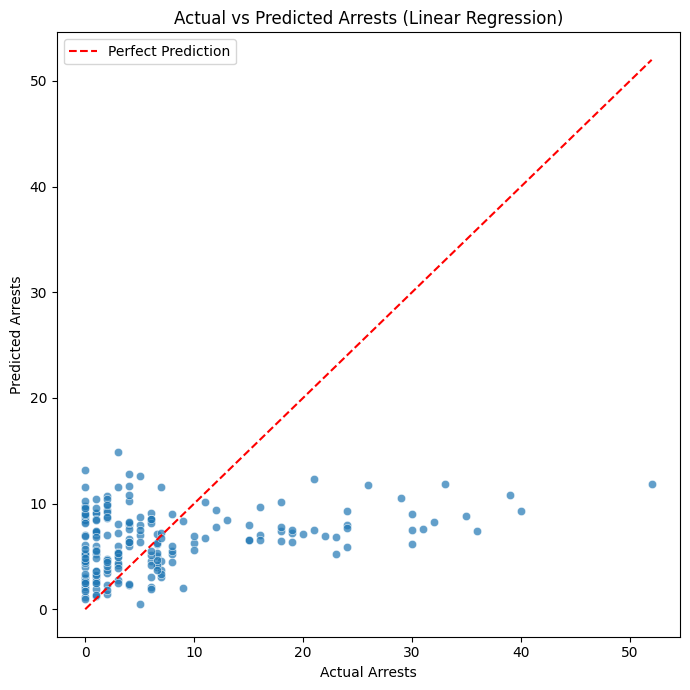

In [35]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=lr_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Arrests')
plt.ylabel('Predicted Arrests')
plt.title('Actual vs Predicted Arrests (Linear Regression)')
plt.legend()
plt.tight_layout()
plt.show()

Linear regression definitely doesn't work. Im going to try random forest to see if that can help

In [36]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest Results:")
print(f"RMSE: {root_mean_squared_error(y_test, rf_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, rf_pred):.3f}")
print(f"R²: {r2_score(y_test, rf_pred):.3f}")

Random Forest Results:
RMSE: 5.440
MAE: 3.401
R²: 0.666


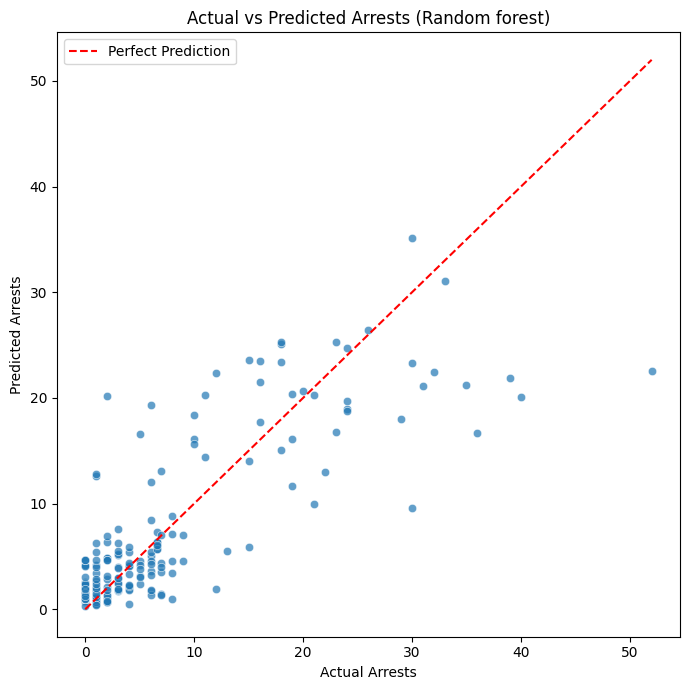

In [37]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=rf_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Arrests')
plt.ylabel('Predicted Arrests')
plt.title('Actual vs Predicted Arrests (Random forest)')
plt.legend()
plt.tight_layout()
plt.show()

Trying to use regression on this data clearly won't work, so instead im going to try to split the arrests into low arrests games and high arrests games and then predict on these separate category's.

### 3.7 - More attempts

So to make two separate category's I need to create labels of what a high arrest game is, and I will be going with above the 75th percentile. Then I just split the games into the high vs normal depending on where they fall in the quantile range.

In [38]:
# Define the threshold and split the training and test sets
high_arrest_threshold = y_train.quantile(0.75)
y_train_class = (y_train > high_arrest_threshold).astype(int)
y_test_class = (y_test > high_arrest_threshold).astype(int)

In [39]:
# Split the test games into their groups
normal_games = X_test[y_test_class == 0].copy()
high_arrest_games = X_test[y_test_class == 1].copy()

# Add arrests for reference
normal_games['arrests'] = y_test[y_test_class == 0]
high_arrest_games['arrests'] = y_test[y_test_class == 1]

Perfect, now im going to predict on normal and high separately.

In [40]:
# Create masks for training data
normal_train_idx = y_train_class == 0
high_train_idx = y_train_class == 1

# Fit models
reg_normal = RandomForestRegressor(n_estimators=100, random_state=42)
reg_normal.fit(X_train[normal_train_idx], y_train[normal_train_idx])

reg_high = RandomForestRegressor(n_estimators=100, random_state=42)
reg_high.fit(X_train[high_train_idx], y_train[high_train_idx])

# Use split based on the threshold
normal_test_idx = y_test_class == 0
high_test_idx = y_test_class == 1

# Make a prediction on both normal and high games
arrest_pred = np.zeros_like(y_test, dtype=float)
arrest_pred[normal_test_idx] = reg_normal.predict(X_test[normal_test_idx])
arrest_pred[high_test_idx] = reg_high.predict(X_test[high_test_idx])

In [41]:
# Class labels for test set
normal_mask = y_test_class == 0
high_mask = y_test_class == 1

print("Normal Games Regression Results:")
print(f"  RMSE: {root_mean_squared_error(y_test[normal_mask], arrest_pred[normal_mask]):.3f}")
print(f"  MAE: {mean_absolute_error(y_test[normal_mask], arrest_pred[normal_mask]):.3f}")
print(f"  R2: {r2_score(y_test[normal_mask], arrest_pred[normal_mask]):.3f}")

print("\nHigh-Arrest Games Regression Results:")
print(f"  RMSE: {root_mean_squared_error(y_test[high_mask], arrest_pred[high_mask]):.3f}")
print(f"  MAE: {mean_absolute_error(y_test[high_mask], arrest_pred[high_mask]):.3f}")
print(f"  R2: {r2_score(y_test[high_mask], arrest_pred[high_mask]):.3f}")

Normal Games Regression Results:
  RMSE: 2.001
  MAE: 1.621
  R2: 0.280

High-Arrest Games Regression Results:
  RMSE: 8.200
  MAE: 6.495
  R2: 0.306


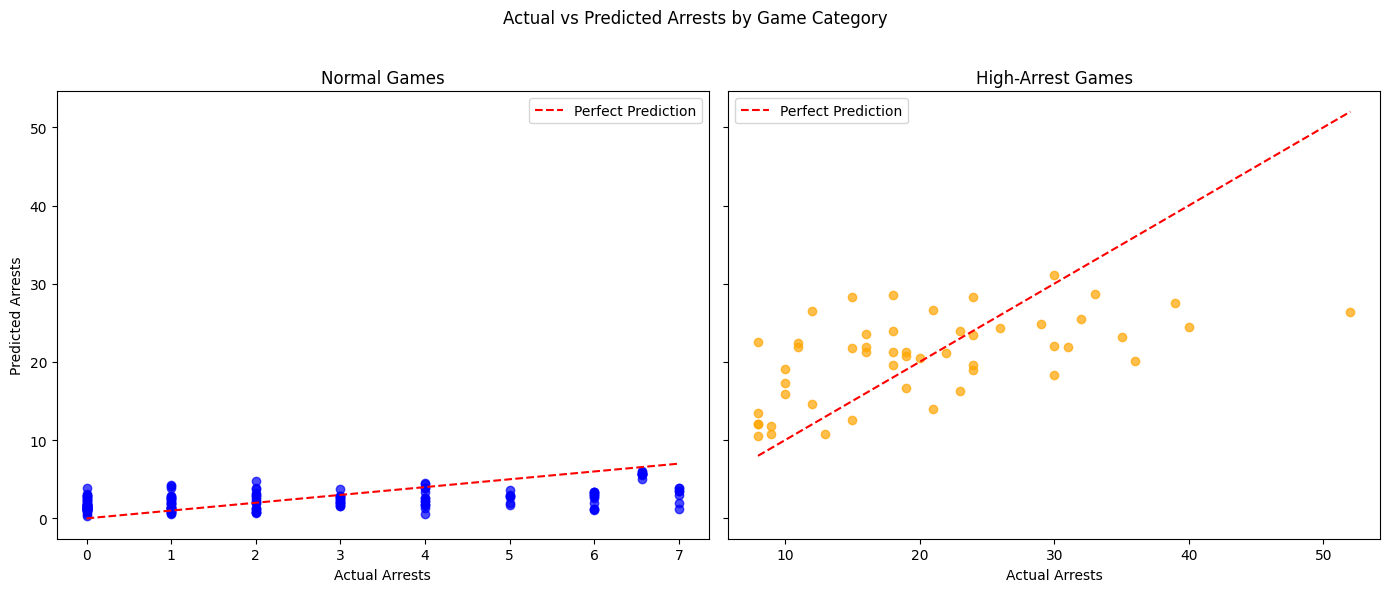

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Normal games
axes[0].scatter(y_test[normal_mask], arrest_pred[normal_mask], alpha=0.7, color='blue')
axes[0].plot([y_test[normal_mask].min(), y_test[normal_mask].max()],
             [y_test[normal_mask].min(), y_test[normal_mask].max()],
             'r--', label='Perfect Prediction')
axes[0].set_title('Normal Games')
axes[0].set_xlabel('Actual Arrests')
axes[0].set_ylabel('Predicted Arrests')
axes[0].legend()

# High-Arrest games
axes[1].scatter(y_test[high_mask], arrest_pred[high_mask], alpha=0.7, color='orange')
axes[1].plot([y_test[high_mask].min(), y_test[high_mask].max()],
             [y_test[high_mask].min(), y_test[high_mask].max()],
             'r--', label='Perfect Prediction')
axes[1].set_title('High-Arrest Games')
axes[1].set_xlabel('Actual Arrests')
axes[1].legend()

plt.suptitle('Actual vs Predicted Arrests by Game Category')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In lab 8 TPOT was introduced, so im going to try that and see if I can find the best model to optimize the results.

In [43]:
# Start TPOT on normal games
tpot_normal = TPOTRegressor(generations=5, population_size=20, verbosity=2, random_state=42, n_jobs=-1)
tpot_normal.fit(X_train[normal_train_idx], y_train[normal_train_idx])

# Predict and evaluate on normal test games
tpot_pred_normal = tpot_normal.predict(X_test[normal_test_idx])

# Evaluation
print("TPOT Results (Normal Games):")
print(f"RMSE: {root_mean_squared_error(y_test[normal_test_idx], tpot_pred_normal):.3f}")
print(f"MAE: {mean_absolute_error(y_test[normal_test_idx], tpot_pred_normal):.3f}")
print(f"R2: {r2_score(y_test[normal_test_idx], tpot_pred_normal):.3f}")

is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor


c:\Users\natec\Data-science-final-project\.venv\Lib\site-packages\sklearn\base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(
c:\Users\natec\Data-science-final-project\.venv\Lib\site-packages\sklearn\base.py:1270: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor


Version 0.12.2 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


                                                                             
Generation 1 - Current best internal CV score: -3.132387094648012
                                                                             
Generation 2 - Current best internal CV score: -3.1214028548394412
                                                                             
Generation 3 - Current best internal CV score: -3.009787147467589
                                                                             
Generation 4 - Current best internal CV score: -3.009787147467589
                                                                              
Generation 5 - Current best internal CV score: -3.009787147467589
                                                                              
Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=5, min_samples_leaf=17, min_samples_split=5)
TPOT Results (Normal Games):
RMSE: 1.937
MAE: 1.518
R2: 0.325


In [44]:
# Next run TPOT on high games
tpot_high = TPOTRegressor(generations=5, population_size=20, verbosity=2, random_state=42, n_jobs=-1)
tpot_high.fit(X_train[high_train_idx], y_train[high_train_idx])

# Predict and evaluate on high-arrest test games
tpot_pred_high = tpot_high.predict(X_test[high_test_idx])

print("\nTPOT Results (High-Arrest Games):")
print(f"RMSE: {root_mean_squared_error(y_test[high_test_idx], tpot_pred_high):.3f}")
print(f"MAE: {mean_absolute_error(y_test[high_test_idx], tpot_pred_high):.3f}")
print(f"R2: {r2_score(y_test[high_test_idx], tpot_pred_high):.3f}")

is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor


c:\Users\natec\Data-science-final-project\.venv\Lib\site-packages\sklearn\base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(
c:\Users\natec\Data-science-final-project\.venv\Lib\site-packages\sklearn\base.py:1270: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor


Version 0.12.2 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


                                                                             
Generation 1 - Current best internal CV score: -102.47070672837658
                                                                             
Generation 2 - Current best internal CV score: -102.47070672837658
                                                                             
Generation 3 - Current best internal CV score: -101.8672338362369
                                                                             
Generation 4 - Current best internal CV score: -101.69167236495316
                                                                              
Generation 5 - Current best internal CV score: -101.21821556176242
                                                                              
Best pipeline: AdaBoostRegressor(PolynomialFeatures(RidgeCV(input_matrix), degree=2, include_bias=False, interaction_only=False), learning_rate=0.01, loss=exponential, n_estimators=100)

TPOT Resu

c:\Users\natec\Data-science-final-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  warnings.warn(


Sadly it doesn't look like TPOT has done much, but im going to quickly make a graph like the last to see what changed

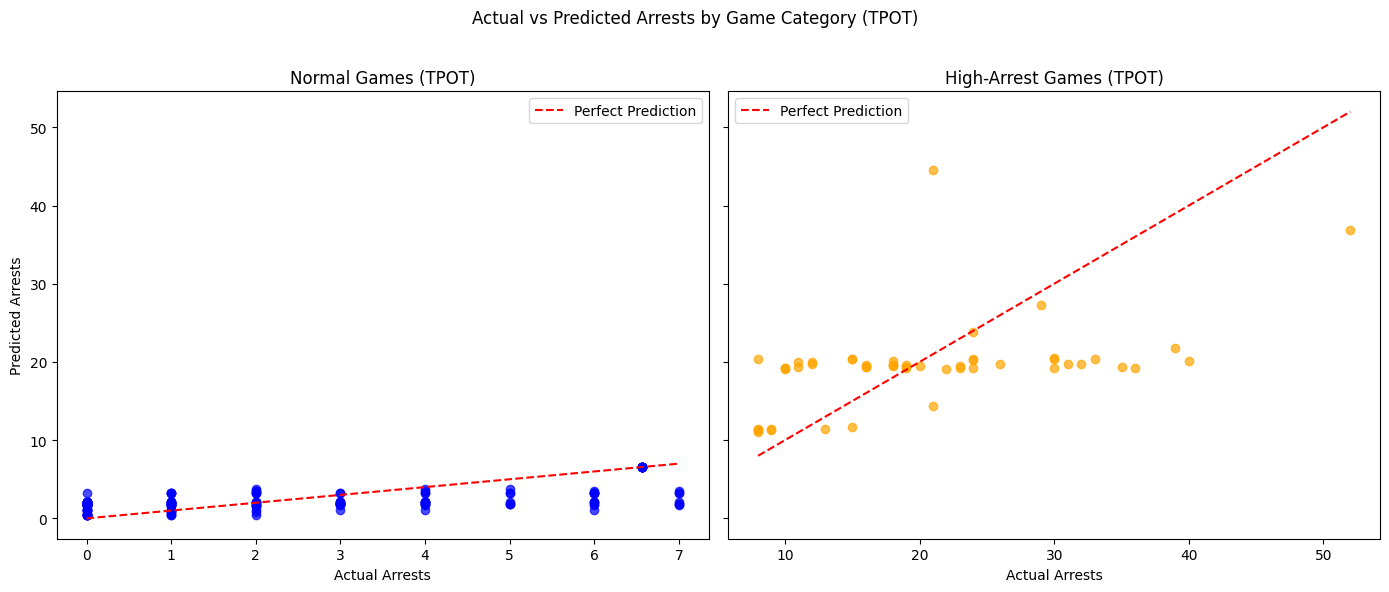

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Normal games
axes[0].scatter(y_test[normal_test_idx], tpot_pred_normal, alpha=0.7, color='blue')
axes[0].plot([y_test[normal_test_idx].min(), y_test[normal_test_idx].max()],
             [y_test[normal_test_idx].min(), y_test[normal_test_idx].max()],
             'r--', label='Perfect Prediction')
axes[0].set_title('Normal Games (TPOT)')
axes[0].set_xlabel('Actual Arrests')
axes[0].set_ylabel('Predicted Arrests')
axes[0].legend()

# High-Arrest games
axes[1].scatter(y_test[high_test_idx], tpot_pred_high, alpha=0.7, color='orange')
axes[1].plot([y_test[high_test_idx].min(), y_test[high_test_idx].max()],
             [y_test[high_test_idx].min(), y_test[high_test_idx].max()],
             'r--', label='Perfect Prediction')
axes[1].set_title('High-Arrest Games (TPOT)')
axes[1].set_xlabel('Actual Arrests')
axes[1].legend()

plt.suptitle('Actual vs Predicted Arrests by Game Category (TPOT)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The problem still exists of outliers skewing the prediction to much and ive accepted that arrests is not really predictable with the data in the dataset. No feature on amount of attendance, No weather data (Worse weather likely leads to less arrests), if the game is a playoff game, etc. Instead I will switch from trying to predict amount of arrests to a classification of if a game will be high arrest or a normal amount of arrests. This will be similar to how I split the data because im defining a high arrest game above the 75th percentile, but I will then need to actually predict. Also I will be using random forest's classifier for the predictions.

### 3.9 - Classifier 

In [46]:
# Define the high arrest games (75th percentile)
high_arrest_threshold = y_train.quantile(0.75)
print(f"High-arrest threshold: {high_arrest_threshold}")

# Create binary target
y_train_class = (y_train > high_arrest_threshold).astype(int)
y_test_class = (y_test > high_arrest_threshold).astype(int)

High-arrest threshold: 7.0


In [47]:
# Make prediction using random forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train_class)
y_pred_class = clf.predict(X_test)

# Print metrics
print("Classification Report (Normal vs High-Arrest):")
print(classification_report(y_test_class, y_pred_class, target_names=["Normal", "High-Arrest"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test_class, y_pred_class))

Classification Report (Normal vs High-Arrest):
              precision    recall  f1-score   support

      Normal       0.88      0.95      0.91       151
 High-Arrest       0.79      0.61      0.69        51

    accuracy                           0.86       202
   macro avg       0.84      0.78      0.80       202
weighted avg       0.86      0.86      0.85       202

Confusion Matrix:
[[143   8]
 [ 20  31]]


Im kind of happy with the classification report as it shows scores in the 90s for normal, but its high arrest scores are in the 70s range. This shows that it can predict a normal amount of arrests with my factors very well but struggles a bit for high arrests.

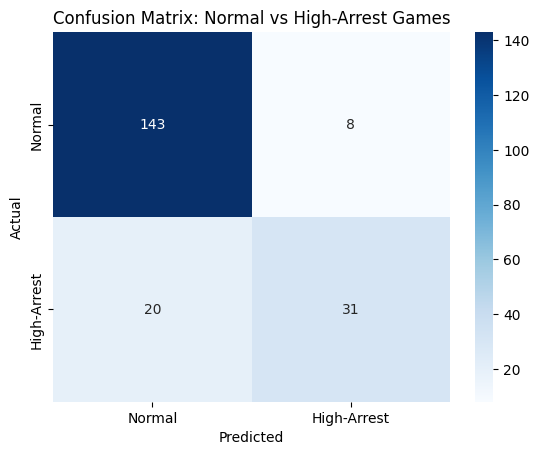

In [48]:
# Print confusion matrix graph
cm = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "High-Arrest"], yticklabels=["Normal", "High-Arrest"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Normal vs High-Arrest Games")
plt.show()

Im kind of happy with the confusion matrix results with the good results for normal, but has some issues with high arrests games. It seems to be predicting most games to be normal (20 false negatives). Next im going to try and work on improving these results a bit to get better results for high arrests games.

## 4 - Final improvements and further questions

After thinking about it overnight im going to try K-Nearest Neighbors Classifier since it worked so well for the beans dataset.

In [56]:
k_range = range(1, 30)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train_class, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

optimal_k = k_range[np.argmax(k_scores)]
print(f"Optimal K: {optimal_k}")

Optimal K: 6


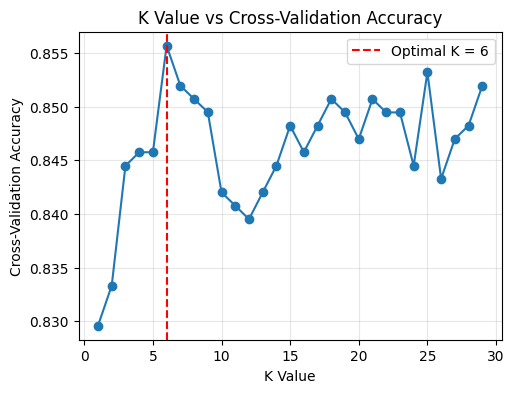

In [57]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(k_range, k_scores, marker='o')
plt.xlabel('K Value')
plt.ylabel('Cross-Validation Accuracy')
plt.title('K Value vs Cross-Validation Accuracy')
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
plt.legend()
plt.grid(True, alpha=0.3)

KNN Classification Report:
              precision    recall  f1-score   support

      Normal       0.86      0.97      0.91       151
 High-Arrest       0.87      0.53      0.66        51

    accuracy                           0.86       202
   macro avg       0.87      0.75      0.79       202
weighted avg       0.86      0.86      0.85       202

Confusion Matrix:
[[147   4]
 [ 24  27]]


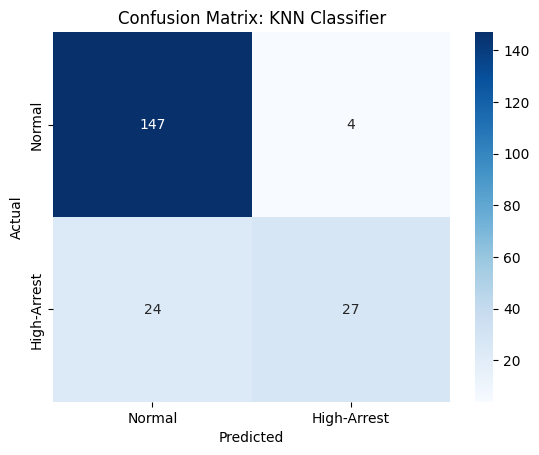

In [58]:
# Create and fit the KNN classifier
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train_class)

# Predict on the test set
y_pred_knn = knn.predict(X_test)

# Evaluate the results
print("KNN Classification Report:")
print(classification_report(y_test_class, y_pred_knn, target_names=["Normal", "High-Arrest"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test_class, y_pred_knn))

# Plot confusion matrix
cm = confusion_matrix(y_test_class, y_pred_knn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "High-Arrest"], yticklabels=["Normal", "High-Arrest"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: KNN Classifier")
plt.show()

While it is a bit better its still just predicting normal too much, and getting many false positives. Because my data is imbalanced im going to try SMOTE which apparently works great with data like mine.

In [60]:
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train_class)

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train_bal, y_train_bal)
y_pred_knn = knn.predict(X_test)

print(classification_report(y_test_class, y_pred_knn, target_names=["Normal", "High-Arrest"]))
print(confusion_matrix(y_test_class, y_pred_knn))

              precision    recall  f1-score   support

      Normal       0.92      0.82      0.87       151
 High-Arrest       0.60      0.78      0.68        51

    accuracy                           0.81       202
   macro avg       0.76      0.80      0.77       202
weighted avg       0.84      0.81      0.82       202

[[124  27]
 [ 11  40]]


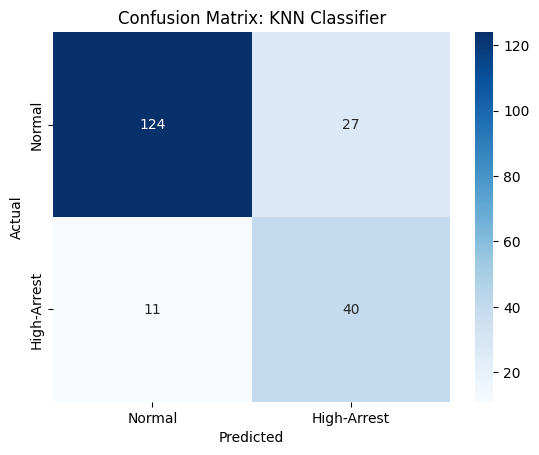

In [61]:
# Plot confusion matrix
cm = confusion_matrix(y_test_class, y_pred_knn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "High-Arrest"], yticklabels=["Normal", "High-Arrest"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: KNN Classifier")
plt.show()

Thats a lot better at predicting high arrests games, but the accuracy did drop a bit to in return. Lastly im going to try XGboost to see if I can get the model a bit better.

XGBoost Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.94      0.94       151
 High-Arrest       0.83      0.84      0.83        51

    accuracy                           0.92       202
   macro avg       0.89      0.89      0.89       202
weighted avg       0.92      0.92      0.92       202

Confusion Matrix:
[[142   9]
 [  8  43]]


c:\Users\natec\Data-science-final-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:39:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


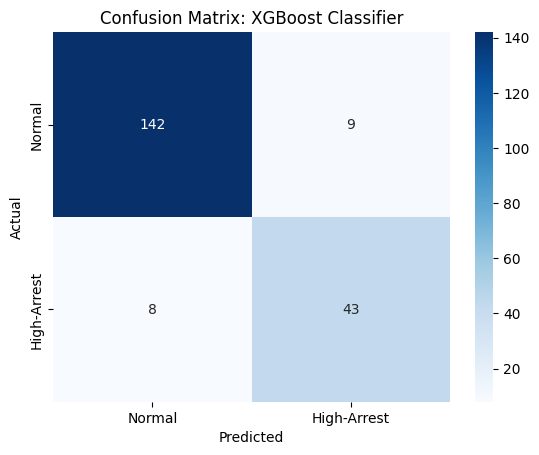

In [64]:
# Calculate the ratio of much weight to give to high arrests (Because my data is imbalanced)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Make the XGBoost classifier with basic parameters
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Using the data from my SMOTE attempt to fit on to try and help it just a little bit more
xgb_clf.fit(X_train_bal, y_train_bal)

# Predict
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluate
print("XGBoost Classification Report:")
print(classification_report(y_test_class, y_pred_xgb, target_names=["Normal", "High-Arrest"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test_class, y_pred_xgb))

# Plot confusion matrix
cm = confusion_matrix(y_test_class, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "High-Arrest"], yticklabels=["Normal", "High-Arrest"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: XGBoost Classifier")
plt.show()

Perfect, finally after way too long of trying different regression and classifier models I have a predict I am completely happy with. XGBoost was able to predict whether a game will have a high amount of arrests (x > 75) or a normal amount of arrests (x < 75). Now in the final section im going to make a visualization of this and make a longer markdown explaining it, along with answering my secondary question, but that part will be very quick and easy.

## 5 - Final answers and predictions